In [0]:
from fastai.text import *
import numpy as np

In [2]:
import fastai; fastai.__version__

'1.0.59'

In [3]:
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz

--2019-11-04 09:59:53--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz’

amazon_review_polar 100%[===================>] 656.45M  16.4MB/s    in 43s     

2019-11-04 10:00:36 (15.4 MB/s) - ‘amazon_review_polarity_csv.tgz’ saved [688339454/688339454]



In [4]:
!tar -xvzf amazon_review_polarity_csv.tgz

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


In [0]:
path = Path('amazon_review_polarity_csv')

In [6]:
path.ls()

[PosixPath('amazon_review_polarity_csv/test.csv'),
 PosixPath('amazon_review_polarity_csv/readme.txt'),
 PosixPath('amazon_review_polarity_csv/train.csv')]

In [7]:
%%time
df = pd.read_csv(path/'train.csv', header = None)
df.head(5)

CPU times: user 14.5 s, sys: 1.3 s, total: 15.8 s
Wall time: 15.8 s


In [8]:
df.rename(columns={0 : 'label', 1 : 'Review_Title', 2 : 'text'}, inplace = True)
df = df[['label', 'text']].copy()
df['is_valid'] = False
print(f"df.shape: {df.shape}")
df.head()

df.shape: (3600000, 3)


,label,text,is_valid
0,2,This sound track was beautiful! It paints the ...,False
1,2,I'm reading a lot of reviews saying that this ...,False
2,2,This soundtrack is my favorite music of all ti...,False
3,2,I truly like this soundtrack and I enjoy video...,False
4,2,"If you've played the game, you know how divine...",False


In [9]:
neg = df.query("label==1").sample(25000, random_state=1)
pos = df.query("label==2").sample(25000, random_state=1)
pos.shape, neg.shape

((25000, 3), (25000, 3))

In [10]:
df = pd.concat([pos, neg]).reset_index(drop=True).copy()
num_val = int(0.1*len(df))
df.iloc[-num_val:,2]=True
df.head()

,label,text,is_valid
0,2,This knee strap has helped me greatly when I'm...,False
1,2,Purchased 2 keyboards for grand daughters for ...,False
2,2,My sons 2dr camry coup needed a new windor reg...,False
3,2,I love this cell phone. I haven't had any trou...,False
4,2,This movie is based on only a slightly fiction...,False


In [0]:
bs=48

In [0]:
data_lm = (TextList.from_df(df, path, cols='text')
                .split_from_df(col=2)
                .label_for_lm()
                .databunch(bs=bs))

In [13]:
data_lm.show_batch()

idx,text
0,"able to sleep most of the time without taking any meds . i sometimes use it while walking and it has helped relieve that pain too and support my knee well . xxmaj the top strap tends to slide down a lot , but the bottom strap has never slipped . xxmaj it needs some sort of side supports to help keep the top strap in place . ( i"
1,"once again xxmaj irving has created an odd lot of characters , mostly likeable , although in the case of xxmaj ted , it is sometimes difficult . xxmaj read this book with your disbelief willingly suspended . xxmaj there are a few too many hard - to - swallow coincidences coupled with a pat ending to make this a xxup great novel , but as usual you read xxmaj"
2,"the basic version seems to work the same and its quality also do n't differs , but basic is $ 20 . xxmaj go to your local walmart / target / kmart and they may have both basic and pro and you can play with the models to see which works best for xxunk or $ 40 ? xxbos i got this ages ago and it still works as good"
3,"it freezes without becoming stiff and works great for icing down after home therapy . xxbos xxmaj this is a really fun movie . i love "" reliving "" life in the 60s and this has it all ! xxmaj just be ready to sing the song from the movie all day after watching it . xxbos xxmaj simple design that 's easy to use . i can understand some"
4,"i felt "" her "" entries were endearing . xxmaj many would agree that if you were to write something of this manner for your child , it should be about the wonderful ways they grew up and the special times that were shared with their family . xxmaj this book would be best enjoyed on a lazy xxmaj saturday or xxmaj sunday afternoon when you have the time to"


In [14]:
len(data_lm.vocab.itos)

28216

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


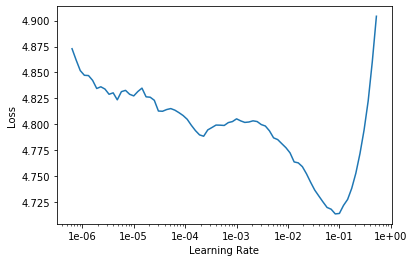

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.086286,3.964493,0.281841,09:47


In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [20]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was a great movie . It is an amazing movie that is also very well done . The cast is very strong . i have a great cast and a lot of great acting and make it
I liked this movie because it was good and it was great . The movie was very funny and enjoyed many of the scenes . xxbos i am not sure how to understand which was the only problem . i is not sure what


In [0]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.787287,3.837858,0.296009,11:27
1,3.718283,3.778946,0.303654,11:26
2,3.523790,3.741859,0.308767,11:24
3,3.335048,3.739779,0.309967,11:24
4,3.196998,3.760168,0.308311,11:25


In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [24]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it shows how God changed my life . i like Jesus but the movie was a really good movie . xxbos i have read the entire Inc. series of books on the Ruined Island .
I liked this movie because my favorite girl group sang the CD . It 's a great soundtrack to be heard if you 're a HUGE fan of The Party . xxbos If you were a fan of


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_clas = (TextList.from_df(df, path, cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=bs))

In [29]:
len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

True

In [30]:
data_clas.show_batch()

text,target
xxbos xxup this xxup is xxup totally xxup one xxup of xxup the xxup best xxup books xxup ever xxup written ! xxup it xxup is a xxup great xxup ending xxup to xxup the xxup whole xxup lord xxup of xxup the xxup rings xxup series . xxup who xxup will xxup win xxup the xxup battle xxup over xxup xxunk xxup earth ? xxup can xxup all xxup,2
"xxbos i xxup love xxup breaking xxup bad , xxup but i xxup hated xxup trying xxup to xxup watch xxup season 4 xxup on xxup amazon . xxup first xxup it xxup played xxup the xxup last xxup episode , xxup which xxup was xxup confusing xxup and a xxup spoiler , xxup then xxup when xxup it xxup played xxup episode xxup one , xxup it xxup kept",1
"xxbos i 've been a fan of xxmaj steve xxmaj young 's , like for - xxup ever , honest - to - xxmaj god , i first saw him at the "" xxmaj young xxmaj folk "" xxmaj sunday afternoon show at the xxmaj newport xxmaj folk xxmaj festival in 1969 . i scoured xxmaj chicago for my first copy of the xxup xxunk record "" xxmaj steve xxmaj",2
"xxbos xxmaj here is a solid compilation of xxmaj ernest xxmaj tubb ; a true xxmaj legend of xxmaj country & xxmaj western xxmaj music . xxmaj folks , xxmaj ernest xxmaj tubb was authentic , and that is what music is all about xxrep 5 . especially xxmaj country xxmaj music . xxmaj noone did more for xxmaj western music than xxup et , and his contribution to true",2
"xxbos xxmaj jackie xxmaj brown ... what can i say ? xxmaj excellent . i loved it . xxmaj elmore xxmaj leonard is the xxup best crime writer ever , and xxmaj quentin xxmaj tarantino is the best crime director ever ... so , they are such a great match . i wo n't give anything away , but the final scene at the mall had me on the edge",2


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [32]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (45000 items)
x: TextList
xxbos xxmaj this knee strap has helped me greatly when i 'm having trouble sleeping from knee and foot pain . i do n't like to take over - the - counter meds all the time ( usually xxunk ) and i refuse to use any prescription pain killers to be able to sleep . xxmaj this knee strap helps relieve both knee and foot pain that i have been able to sleep most of the time without taking any meds . i sometimes use it while walking and it has helped relieve that pain too and support my knee well . xxmaj the top strap tends to slide down a lot , but the bottom strap has never slipped . xxmaj it needs some sort of side supports to help keep the top strap in place . ( i bought 2 of these from different vendors , so i 'm leaving feedback for both . ),xxbos xxmaj purchased 2 keyboards for grand daughters for xxmaj christmas . xxmaj they arrived quickly , brand new , as advertised . xxmaj the kids loved them and they were

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


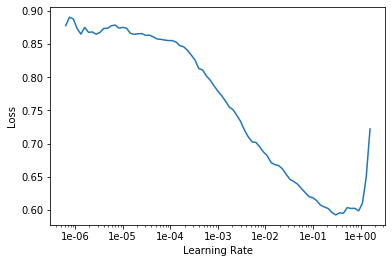

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.336556,0.318714,0.868000,03:27


In [36]:
learn.predict("I really loved that movie, it was awesome!")

(Category 2, tensor(1), tensor([0.0114, 0.9886]))

In [37]:
learn.predict("I enjoyed using the dishwasher.")

(Category 2, tensor(1), tensor([0.0619, 0.9381]))

In [38]:
learn.predict("The product was bit too expensive for the quality provided.")

(Category 1, tensor(0), tensor([0.7888, 0.2112]))

In [40]:
learn.predict("These earphones are really cheap and have a great sound.")

(Category 2, tensor(1), tensor([0.0756, 0.9244]))

In [41]:
learn.predict("The fan is suitable for a small room.")

(Category 2, tensor(1), tensor([0.0583, 0.9417]))

In [42]:
learn.predict("The bag I ordered did not match the one shown on the website.")

(Category 1, tensor(0), tensor([0.9263, 0.0737]))

In [43]:
learn.predict("I did not receive the refund for over a week.")

(Category 1, tensor(0), tensor([0.9843, 0.0157]))